In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
import joblib
import os

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

# Create directories for saving models and data
os.makedirs('models', exist_ok=True)
os.makedirs('processed_data', exist_ok=True)


Matplotlib is building the font cache; this may take a moment.


## 1. Data Loading and Initial Exploration


In [8]:
def load_data():
    """Load train, test, and data dictionary files"""
    train_df = pd.read_csv('data/train.csv')
    test_df = pd.read_csv('data/test.csv')
    data_dict = pd.read_csv('data/data_dictionary.csv', delimiter='\t')
    
    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    
    return train_df, test_df, data_dict

train_df, test_df, data_dict = load_data()


Training data shape: (8523, 12)
Test data shape: (5681, 11)


In [9]:
# Display data dictionary for reference
print("Data Dictionary:")
display(data_dict)


Data Dictionary:


,Variable,Description
0,Item_Identifier,Unique product ID
1,Item_Weight,Weight of product
2,Item_Fat_Content,Whether the product is low fat or not
3,Item_Visibility,The % of total display area of all products in...
4,Item_Type,The category to which the product belongs
5,Item_MRP,Maximum Retail Price (list price) of the product
6,Outlet_Identifier,Unique store ID
7,Outlet_Establishment_Year,The year in which store was established
8,Outlet_Size,The size of the store in terms of ground area ...
9,Outlet_Location_Type,The type of city in which the store is located


In [11]:
def basic_info(df, name):
    """Display basic information about the dataset"""
    print(f"\n=== {name} Dataset Info ===")
    print(f"Shape: {df.shape}")
    print(f"\nData Types:")
    print(df.dtypes)
    print(f"\nMissing Values:")
    missing_info = df.isnull().sum()
    missing_percent = (missing_info / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing_info,
        'Missing_Percentage': missing_percent
    })
    print(missing_df[missing_df['Missing_Count'] > 0])
    
basic_info(train_df, "Training")
basic_info(test_df, "Test")



=== Training Dataset Info ===
Shape: (8523, 12)

Data Types:
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

Missing Values:
             Missing_Count  Missing_Percentage
Item_Weight           1463           17.165317
Outlet_Size           2410           28.276428

=== Test Dataset Info ===
Shape: (5681, 11)

Data Types:
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outle

In [12]:
# First few rows of training data
print("First 5 rows of training data:")
display(train_df.head())

print("\nFirst 5 rows of test data:")
display(test_df.head())


First 5 rows of training data:


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052



First 5 rows of test data:


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


## 2. Exploratory Data Analysis (EDA)


Numerical Features Summary:


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,7060.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867
std,4.643456,0.051598,62.275067,8.371760
min,4.555000,0.000000,31.290000,1985.000000
25%,8.773750,0.026989,93.826500,1987.000000
50%,12.600000,0.053931,143.012800,1999.000000
75%,16.850000,0.094585,185.643700,2004.000000
max,21.350000,0.328391,266.888400,2009.000000


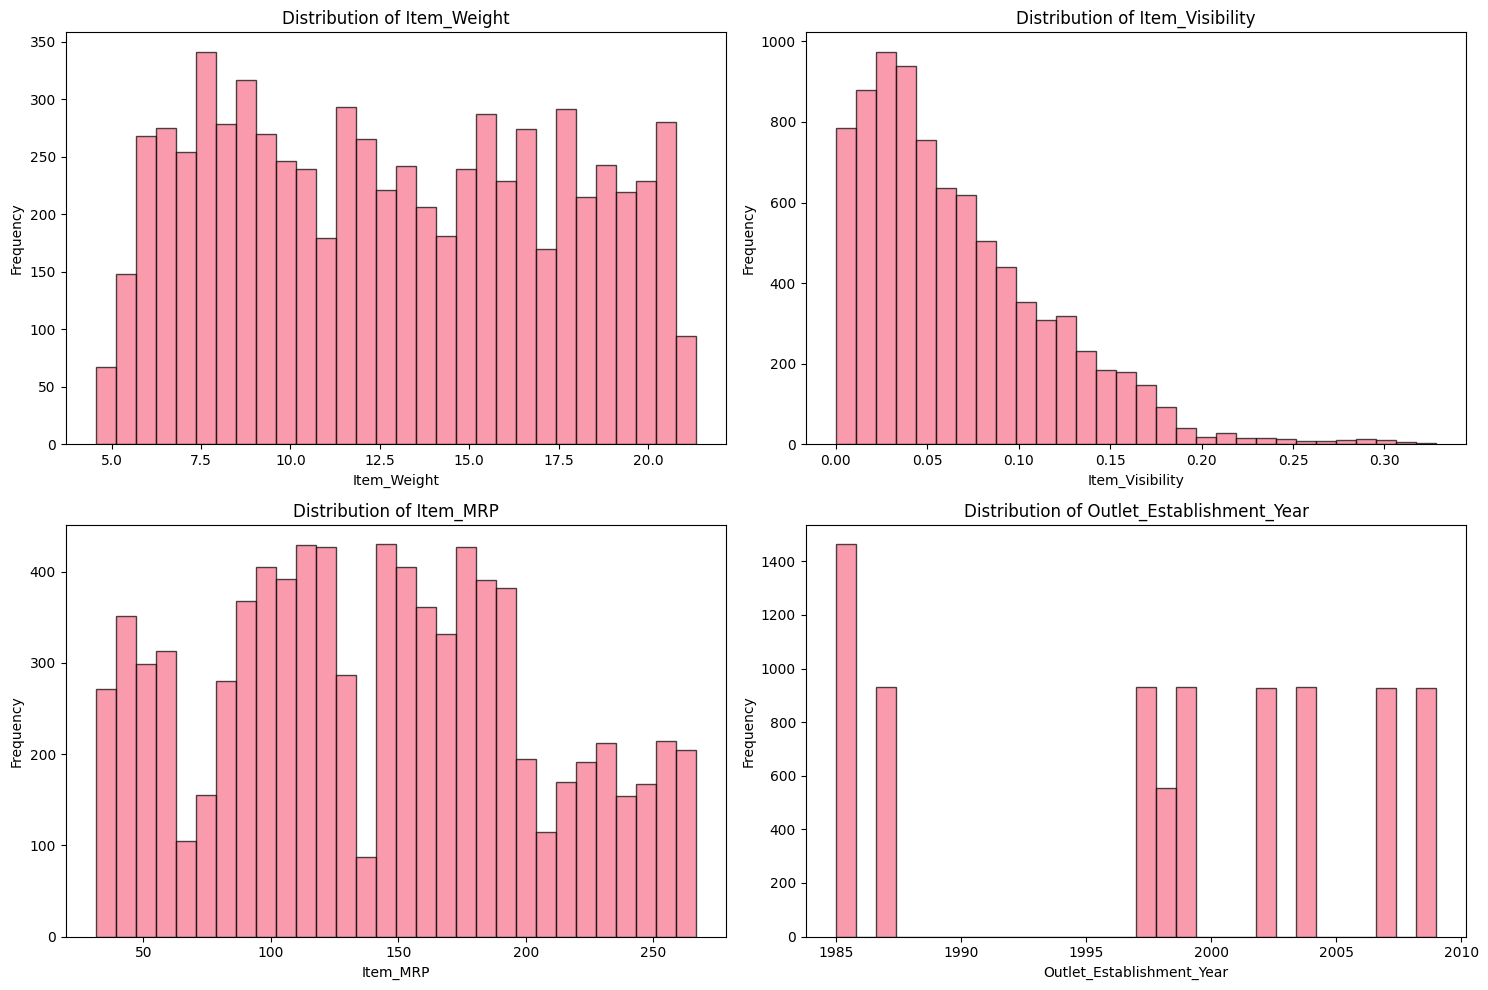

In [13]:
def analyze_numerical_features(df):
    """Analyze numerical features distribution and statistics"""
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Item_Outlet_Sales' in numerical_cols:
        numerical_cols.remove('Item_Outlet_Sales')  # Handle target separately
    
    print("Numerical Features Summary:")
    display(df[numerical_cols].describe())
    
    # Distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numerical_cols[:4]):
        axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return numerical_cols

numerical_features = analyze_numerical_features(train_df)


Target Variable (Item_Outlet_Sales) Analysis:
Mean: 2181.29
Median: 1794.33
Std: 1706.50
Min: 33.29
Max: 13086.96


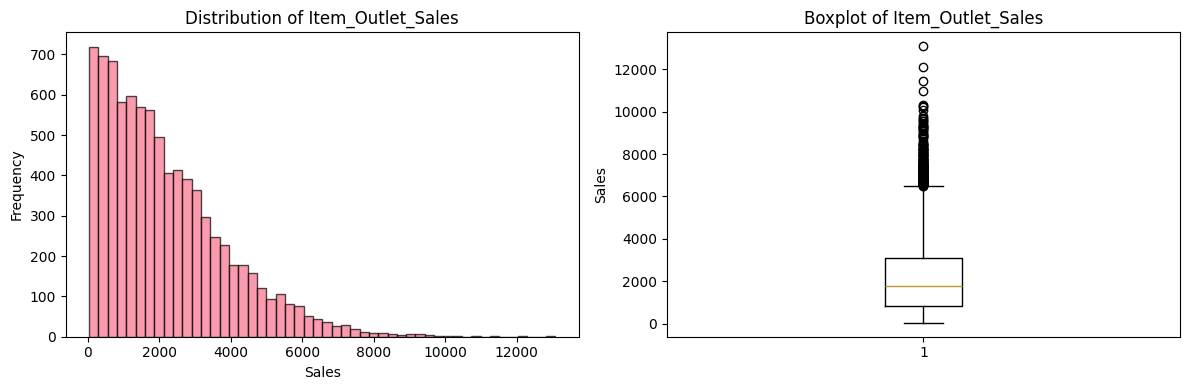

In [14]:
# Target variable analysis
if 'Item_Outlet_Sales' in train_df.columns:
    print("Target Variable (Item_Outlet_Sales) Analysis:")
    print(f"Mean: {train_df['Item_Outlet_Sales'].mean():.2f}")
    print(f"Median: {train_df['Item_Outlet_Sales'].median():.2f}")
    print(f"Std: {train_df['Item_Outlet_Sales'].std():.2f}")
    print(f"Min: {train_df['Item_Outlet_Sales'].min():.2f}")
    print(f"Max: {train_df['Item_Outlet_Sales'].max():.2f}")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(train_df['Item_Outlet_Sales'], bins=50, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Item_Outlet_Sales')
    plt.xlabel('Sales')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(train_df['Item_Outlet_Sales'])
    plt.title('Boxplot of Item_Outlet_Sales')
    plt.ylabel('Sales')
    
    plt.tight_layout()
    plt.show()


Categorical Features Summary:

Item_Identifier: 1559 unique values
Item_Identifier
FDW13    10
FDG33    10
NCF42     9
FDW26     9
FDX31     9
Name: count, dtype: int64

Item_Fat_Content: 5 unique values
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Item_Type: 16 unique values
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Name: count, dtype: int64

Outlet_Identifier: 10 unique values
Outlet_Identifier
OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
Name: count, dtype: int64

Outlet_Size: 3 unique values
Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

Outlet_Location_Type: 3 unique values
Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: count, dtype: int64

Outlet_Type: 4 unique values
Outlet_Type
Supermarket Type1    

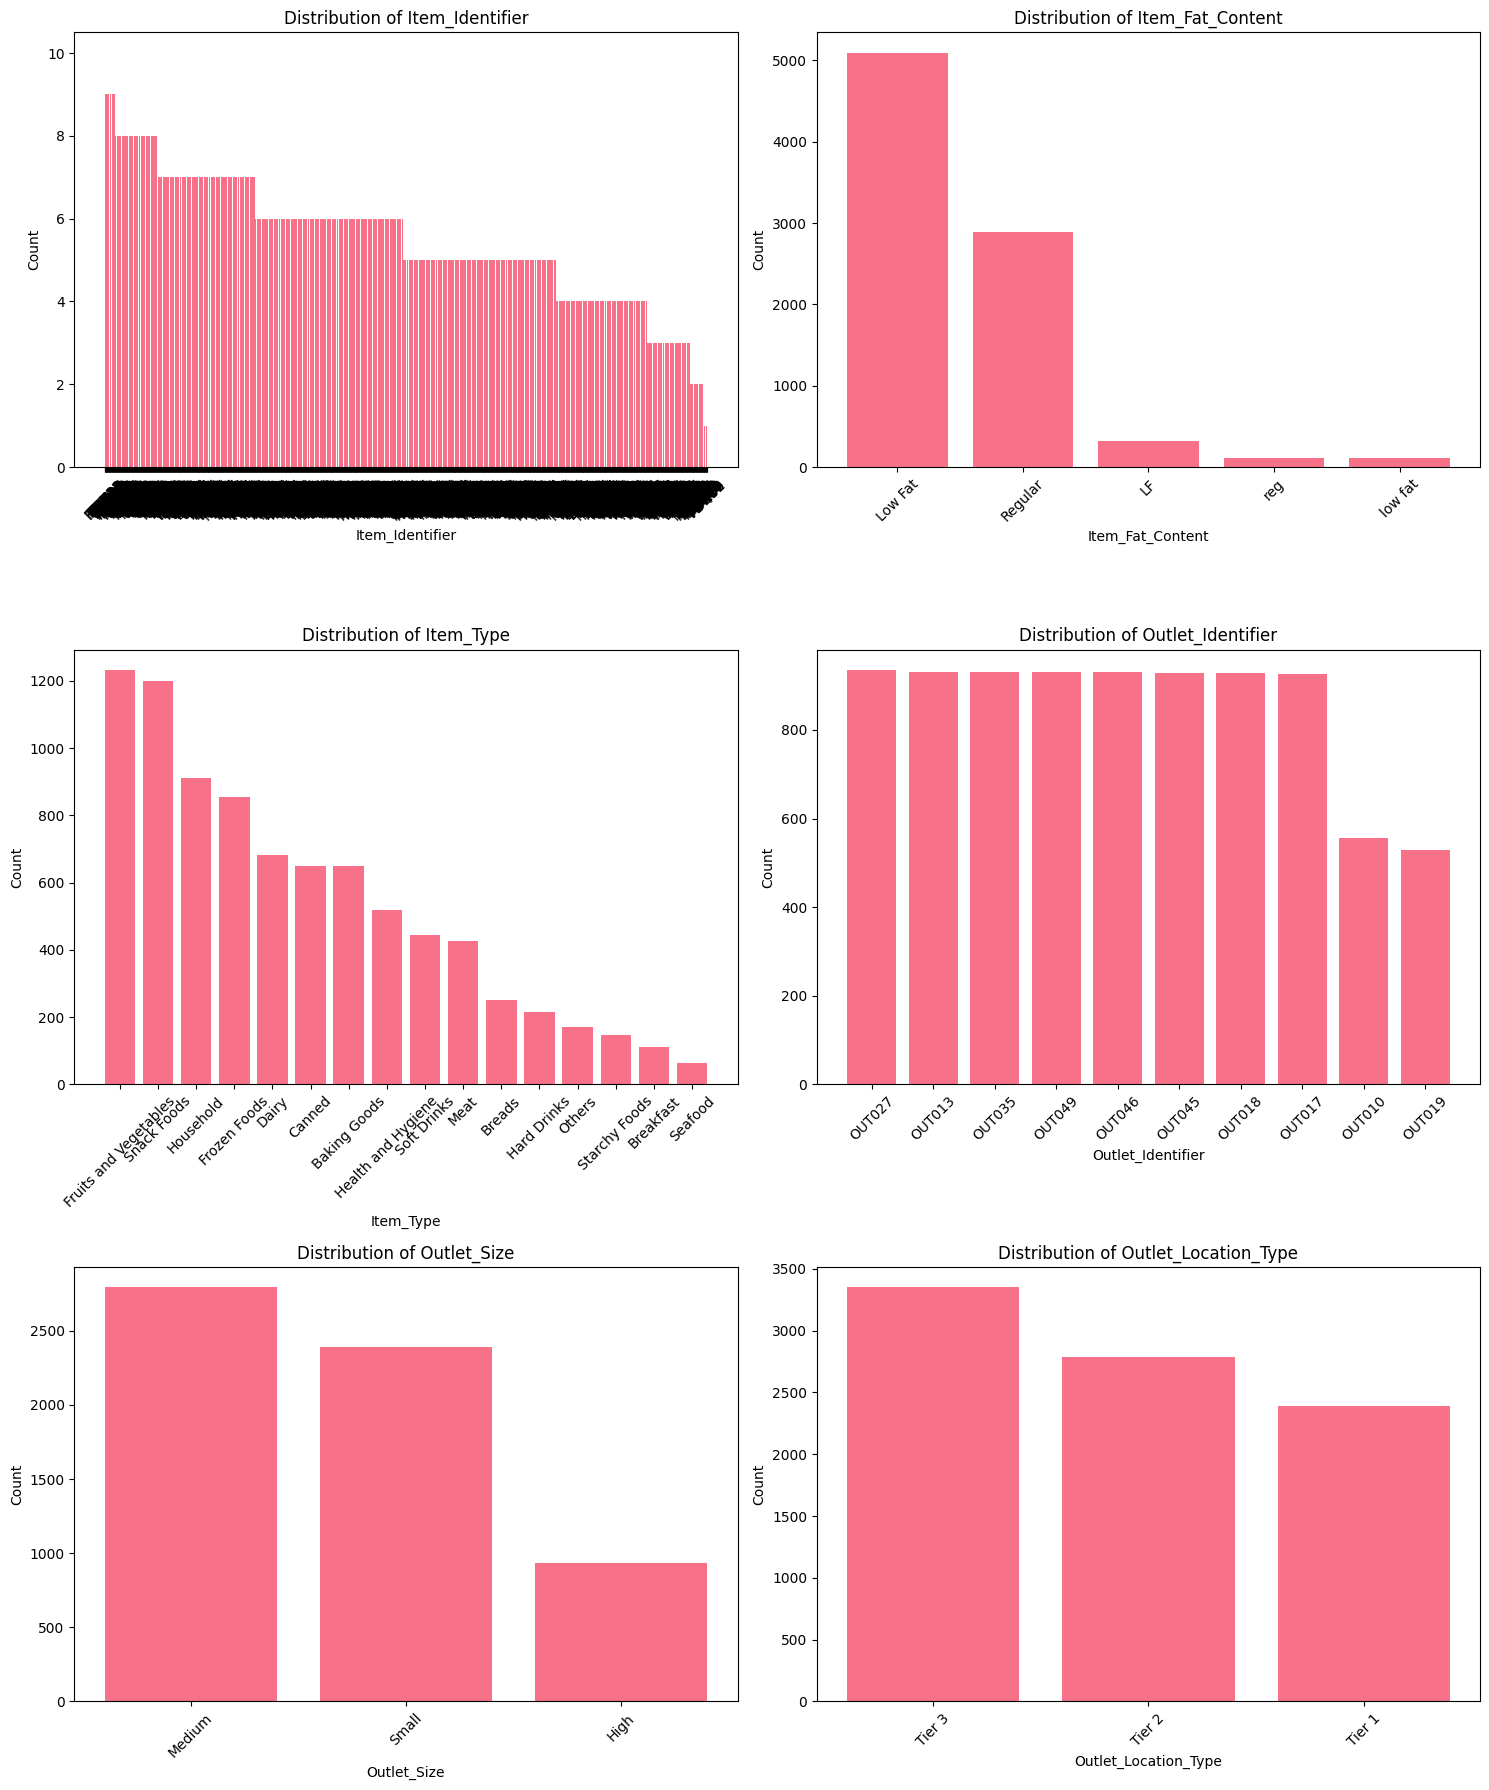

In [15]:
def analyze_categorical_features(df):
    """Analyze categorical features distribution"""
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print("Categorical Features Summary:")
    for col in categorical_cols:
        print(f"\n{col}: {df[col].nunique()} unique values")
        print(df[col].value_counts().head())
    
    # Plot categorical distributions
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    axes = axes.ravel()
    
    for i, col in enumerate(categorical_cols[:6]):
        value_counts = df[col].value_counts()
        axes[i].bar(range(len(value_counts)), value_counts.values)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return categorical_cols

categorical_features = analyze_categorical_features(train_df)


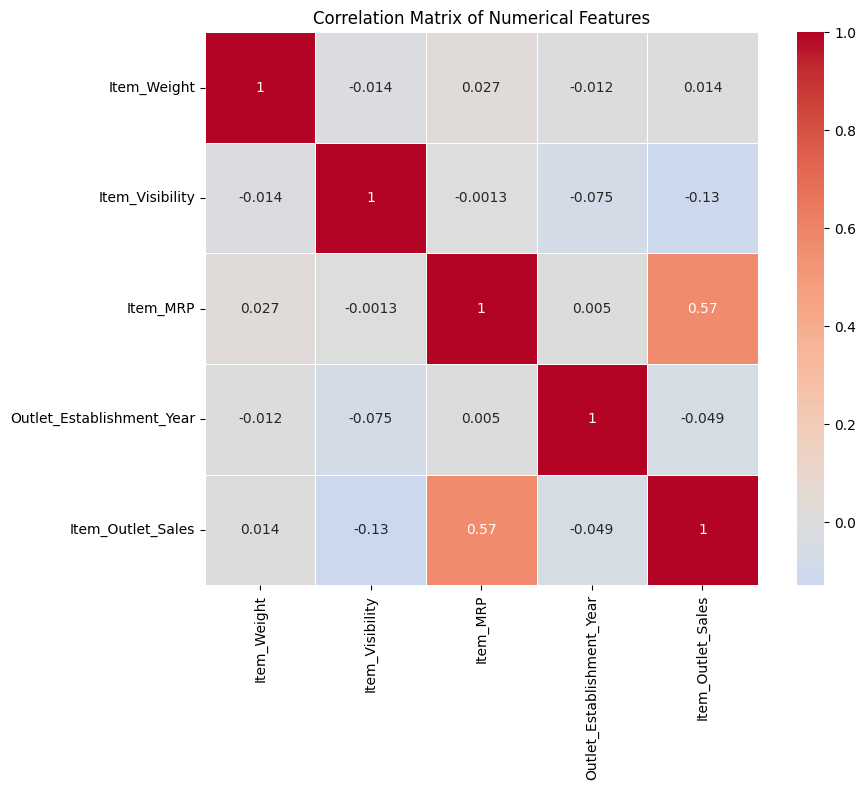


Feature correlation with target:
Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64


In [16]:
# Correlation analysis
if 'Item_Outlet_Sales' in train_df.columns:
    corr_matrix = train_df[numerical_features + ['Item_Outlet_Sales']].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
    
    # Feature correlation with target
    target_corr = corr_matrix['Item_Outlet_Sales'].sort_values(ascending=False)
    print("\nFeature correlation with target:")
    print(target_corr)


In [17]:
def clean_data(df):
    """Clean and standardize data"""
    df_clean = df.copy()
    
    # Standardize Item_Fat_Content values
    fat_content_mapping = {
        'LF': 'Low Fat',
        'reg': 'Regular',
        'low fat': 'Low Fat'
    }
    df_clean['Item_Fat_Content'] = df_clean['Item_Fat_Content'].replace(fat_content_mapping)
    
    # Handle non-consumable items (should not have fat content)
    non_consumable = ['Health and Hygiene', 'Household', 'Others']
    df_clean.loc[df_clean['Item_Type'].isin(non_consumable), 'Item_Fat_Content'] = 'Non-Edible'
    
    print("Data cleaning completed")
    print(f"Item_Fat_Content values after cleaning: {df_clean['Item_Fat_Content'].unique()}")
    
    return df_clean

train_clean = clean_data(train_df)
test_clean = clean_data(test_df)


Data cleaning completed
Item_Fat_Content values after cleaning: ['Low Fat' 'Regular' 'Non-Edible']
Data cleaning completed
Item_Fat_Content values after cleaning: ['Low Fat' 'Regular' 'Non-Edible']


In [18]:
def handle_missing_values(train_df, test_df):
    """Handle missing values in both train and test datasets"""
    train_processed = train_df.copy()
    test_processed = test_df.copy()
    
    # Combine for consistent imputation
    combined_df = pd.concat([train_processed, test_processed], ignore_index=True)
    
    # Handle Item_Weight missing values (numerical)
    if combined_df['Item_Weight'].isnull().sum() > 0:
        # Impute based on Item_Identifier (same product should have same weight)
        item_weight_avg = combined_df.groupby('Item_Identifier')['Item_Weight'].mean()
        missing_weight_mask = combined_df['Item_Weight'].isnull()
        
        for idx in combined_df[missing_weight_mask].index:
            item_id = combined_df.loc[idx, 'Item_Identifier']
            if item_id in item_weight_avg and not pd.isna(item_weight_avg[item_id]):
                combined_df.loc[idx, 'Item_Weight'] = item_weight_avg[item_id]
        
        # Fill remaining missing values with overall mean
        combined_df['Item_Weight'].fillna(combined_df['Item_Weight'].mean(), inplace=True)
    
    # Handle Outlet_Size missing values (categorical)
    if combined_df['Outlet_Size'].isnull().sum() > 0:
        # Impute based on Outlet_Type mode
        outlet_size_mode = combined_df.groupby('Outlet_Type')['Outlet_Size'].apply(
            lambda x: x.mode()[0] if not x.mode().empty else 'Medium'
        )
        
        missing_size_mask = combined_df['Outlet_Size'].isnull()
        for idx in combined_df[missing_size_mask].index:
            outlet_type = combined_df.loc[idx, 'Outlet_Type']
            combined_df.loc[idx, 'Outlet_Size'] = outlet_size_mode[outlet_type]
    
    # Handle Item_Visibility = 0 (treat as missing)
    zero_visibility_mask = combined_df['Item_Visibility'] == 0
    if zero_visibility_mask.sum() > 0:
        # Replace with mean visibility for that product
        item_visibility_mean = combined_df[combined_df['Item_Visibility'] > 0].groupby('Item_Identifier')['Item_Visibility'].mean()
        
        for idx in combined_df[zero_visibility_mask].index:
            item_id = combined_df.loc[idx, 'Item_Identifier']
            if item_id in item_visibility_mean:
                combined_df.loc[idx, 'Item_Visibility'] = item_visibility_mean[item_id]
            else:
                combined_df.loc[idx, 'Item_Visibility'] = combined_df['Item_Visibility'].mean()
    
    # Split back to train and test
    train_len = len(train_processed)
    train_processed = combined_df[:train_len].copy()
    test_processed = combined_df[train_len:].copy().reset_index(drop=True)
    
    print("Missing value treatment completed")
    print(f"Training data missing values: {train_processed.isnull().sum().sum()}")
    print(f"Test data missing values: {test_processed.isnull().sum().sum()}")
    
    return train_processed, test_processed

train_clean, test_clean = handle_missing_values(train_clean, test_clean)


Missing value treatment completed
Training data missing values: 0
Test data missing values: 5681


In [19]:
def detect_and_handle_outliers(df, columns, method='iqr'):
    """Detect and handle outliers using IQR method"""
    df_processed = df.copy()
    outlier_info = {}
    
    for col in columns:
        if col in df_processed.columns and df_processed[col].dtype in ['int64', 'float64']:
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers_mask = (df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)
            outliers_count = outliers_mask.sum()
            
            if outliers_count > 0:
                outlier_info[col] = {
                    'count': outliers_count,
                    'percentage': (outliers_count / len(df_processed)) * 100,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                }
                
                # Cap outliers instead of removing them
                df_processed.loc[df_processed[col] < lower_bound, col] = lower_bound
                df_processed.loc[df_processed[col] > upper_bound, col] = upper_bound
    
    print("Outlier Analysis and Treatment:")
    for col, info in outlier_info.items():
        print(f"{col}: {info['count']} outliers ({info['percentage']:.2f}%) capped")
    
    return df_processed, outlier_info

# Handle outliers in numerical features
numeric_cols_for_outliers = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
train_clean, outlier_info = detect_and_handle_outliers(train_clean, numeric_cols_for_outliers)

# Apply same bounds to test data
for col, info in outlier_info.items():
    if col in test_clean.columns:
        test_clean.loc[test_clean[col] < info['lower_bound'], col] = info['lower_bound']
        test_clean.loc[test_clean[col] > info['upper_bound'], col] = info['upper_bound']


Outlier Analysis and Treatment:
Item_Visibility: 143 outliers (1.68%) capped


In [20]:
def create_new_features(df):
    """Create new features from existing ones"""
    df_featured = df.copy()
    
    # Extract item category from Item_Identifier
    df_featured['Item_Category'] = df_featured['Item_Identifier'].str[:2]
    
    # Years since outlet establishment
    df_featured['Outlet_Years'] = 2013 - df_featured['Outlet_Establishment_Year']
    
    # Item visibility mean ratio
    item_visibility_mean = df_featured.groupby('Item_Identifier')['Item_Visibility'].mean().reset_index()
    item_visibility_mean.columns = ['Item_Identifier', 'Item_Visibility_Mean']
    df_featured = df_featured.merge(item_visibility_mean, on='Item_Identifier', how='left')
    df_featured['Item_Visibility_MeanRatio'] = df_featured['Item_Visibility'] / df_featured['Item_Visibility_Mean']
    
    # Item type combined (broader categories)
    item_type_mapping = {
        'Dairy': 'Food',
        'Soft Drinks': 'Drinks', 
        'Meat': 'Food',
        'Fruits and Vegetables': 'Food',
        'Household': 'Non-Consumable',
        'Baking Goods': 'Food',
        'Snack Foods': 'Food',
        'Frozen Foods': 'Food',
        'Breakfast': 'Food',
        'Health and Hygiene': 'Non-Consumable',
        'Hard Drinks': 'Drinks',
        'Canned': 'Food',
        'Breads': 'Food',
        'Starchy Foods': 'Food',
        'Others': 'Non-Consumable',
        'Seafood': 'Food'
    }
    df_featured['Item_Type_Combined'] = df_featured['Item_Type'].map(item_type_mapping)
    
    # Price per unit weight
    df_featured['Price_per_Unit_Weight'] = df_featured['Item_MRP'] / df_featured['Item_Weight']
    
    # Outlet type and size combination
    df_featured['Outlet_Type_Size'] = df_featured['Outlet_Type'] + '_' + df_featured['Outlet_Size']
    
    print("Feature engineering completed")
    print(f"New features created: Item_Category, Outlet_Years, Item_Visibility_MeanRatio, Item_Type_Combined, Price_per_Unit_Weight, Outlet_Type_Size")
    print(f"Total features: {df_featured.shape[1]}")
    
    return df_featured

train_featured = create_new_features(train_clean)
test_featured = create_new_features(test_clean)


Feature engineering completed
New features created: Item_Category, Outlet_Years, Item_Visibility_MeanRatio, Item_Type_Combined, Price_per_Unit_Weight, Outlet_Type_Size
Total features: 19
Feature engineering completed
New features created: Item_Category, Outlet_Years, Item_Visibility_MeanRatio, Item_Type_Combined, Price_per_Unit_Weight, Outlet_Type_Size
Total features: 19


In [21]:
def prepare_for_modeling(train_df, test_df):
    """Prepare data for modeling with encoding and scaling"""
    train_model = train_df.copy()
    test_model = test_df.copy()
    
    # Separate target variable
    if 'Item_Outlet_Sales' in train_model.columns:
        target = train_model['Item_Outlet_Sales']
        train_model = train_model.drop('Item_Outlet_Sales', axis=1)
    
    # Store identifiers for submission
    train_ids = train_model[['Item_Identifier', 'Outlet_Identifier']].copy()
    test_ids = test_model[['Item_Identifier', 'Outlet_Identifier']].copy()
    
    # Remove identifier columns for modeling
    id_cols = ['Item_Identifier', 'Outlet_Identifier']
    train_model = train_model.drop(id_cols, axis=1)
    test_model = test_model.drop(id_cols, axis=1)
    
    # Drop helper columns
    if 'Item_Visibility_Mean' in train_model.columns:
        train_model = train_model.drop('Item_Visibility_Mean', axis=1)
        test_model = test_model.drop('Item_Visibility_Mean', axis=1)
    
    # Combine for consistent encoding
    combined_df = pd.concat([train_model, test_model], ignore_index=True)
    
    # Label encode categorical variables
    label_encoders = {}
    categorical_cols = combined_df.select_dtypes(include=['object']).columns.tolist()
    
    for col in categorical_cols:
        le = LabelEncoder()
        combined_df[col] = le.fit_transform(combined_df[col].astype(str))
        label_encoders[col] = le
    
    # Split back
    train_len = len(train_model)
    train_encoded = combined_df[:train_len].copy()
    test_encoded = combined_df[train_len:].copy().reset_index(drop=True)
    
    # Scale numerical features
    numerical_cols = train_encoded.select_dtypes(include=[np.number]).columns.tolist()
    scaler = StandardScaler()
    
    train_encoded[numerical_cols] = scaler.fit_transform(train_encoded[numerical_cols])
    test_encoded[numerical_cols] = scaler.transform(test_encoded[numerical_cols])
    
    print("Encoding and scaling completed")
    print(f"Features for modeling: {train_encoded.shape[1]}")
    print(f"Categorical columns encoded: {len(categorical_cols)}")
    print(f"Numerical columns scaled: {len(numerical_cols)}")
    
    return train_encoded, test_encoded, target, label_encoders, scaler, train_ids, test_ids

X_train, X_test, y_train, encoders, scaler, train_ids, test_ids = prepare_for_modeling(train_featured, test_featured)


Encoding and scaling completed
Features for modeling: 16
Categorical columns encoded: 8
Numerical columns scaled: 16


In [22]:
# Save processed datasets
train_final = X_train.copy()
train_final['Item_Outlet_Sales'] = y_train
train_final.to_csv('processed_data/train_cleaned.csv', index=False)

X_test.to_csv('processed_data/test_cleaned.csv', index=False)
train_ids.to_csv('processed_data/train_ids.csv', index=False)
test_ids.to_csv('processed_data/test_ids.csv', index=False)

# Save preprocessing objects
joblib.dump(encoders, 'models/label_encoders.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(outlier_info, 'models/outlier_bounds.pkl')

print("All processed data and preprocessing objects saved successfully")
print(f"\nFinal dataset shapes:")
print(f"Training: {train_final.shape}")
print(f"Test: {X_test.shape}")
print(f"\nFiles saved:")
print("- processed_data/train_cleaned.csv")
print("- processed_data/test_cleaned.csv")
print("- processed_data/train_ids.csv")
print("- processed_data/test_ids.csv")
print("- models/label_encoders.pkl")
print("- models/scaler.pkl")
print("- models/outlier_bounds.pkl")


All processed data and preprocessing objects saved successfully

Final dataset shapes:
Training: (8523, 16)
Test: (5681, 16)

Files saved:
- processed_data/train_cleaned.csv
- processed_data/test_cleaned.csv
- processed_data/train_ids.csv
- processed_data/test_ids.csv
- models/label_encoders.pkl
- models/scaler.pkl
- models/outlier_bounds.pkl


In [23]:
# Final data overview
print("Preprocessing Pipeline Summary:")
print(f"Original training data: {train_df.shape}")
print(f"Final training data: {train_final.shape}")
print(f"Original test data: {test_df.shape}")
print(f"Final test data: {X_test.shape}")
print(f"\nFeatures in final dataset:")
print(list(X_train.columns))


Preprocessing Pipeline Summary:
Original training data: (8523, 12)
Final training data: (8523, 16)
Original test data: (5681, 11)
Final test data: (5681, 16)

Features in final dataset:
['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category', 'Outlet_Years', 'Item_Visibility_MeanRatio', 'Item_Type_Combined', 'Price_per_Unit_Weight', 'Outlet_Type_Size', 'Item_Outlet_Sales']
